In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load RFM data
rfm = pd.read_csv("data/rfm_data.csv")

# Quick look
rfm.head()

,Recency,Frequency,Monetary
0,326,1,77183.60
1,2,7,4310.00
2,75,4,1797.24
3,19,1,1757.55
4,310,1,334.40


#Preparing Data for Clustering

##Scale the RFM Features

K means is senesitive to the scale of features. SO, standardizing the data (mean=0, std= 1)

In [13]:
# Select RFM columns
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert back to DataFrame for convenience
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
print(rfm_scaled_df.describe())

            Recency     Frequency      Monetary
count  4.338000e+03  4.338000e+03  4.338000e+03
mean   2.702618e-17  1.801745e-17  1.965540e-17
std    1.000115e+00  1.000115e+00  1.000115e+00
min   -9.153401e-01 -4.250965e-01 -2.276151e-01
25%   -7.453445e-01 -4.250965e-01 -1.939190e-01
50%   -4.153533e-01 -2.951776e-01 -1.536162e-01
75%    4.946227e-01  9.457903e-02 -4.319704e-02
max    2.814561e+00  2.659803e+01  3.096074e+01


Confirming standardization says mean approx 0 and std is also approx 1.

#Identifying Optimal Number of Clusters

##Using the Elbow Method

Finding the best number of clusters by plotting intertia vs number of clusters.

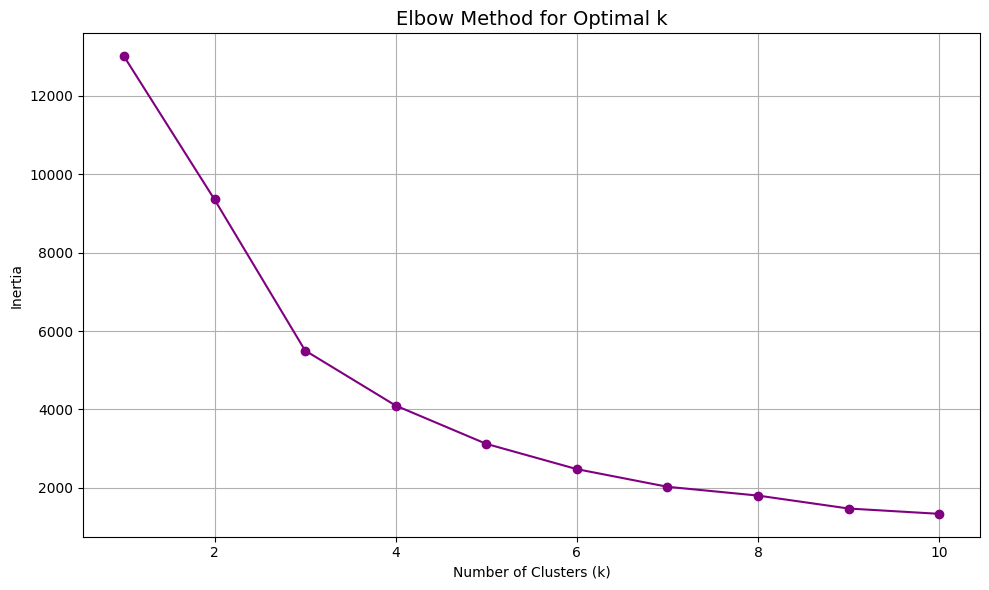

In [14]:
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Calculate inertia for different k values
inertia = []
k_range = range(1, 11)  # Test 1 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', color='purple')
plt.title("Elbow Method for Optimal k", fontsize=14)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/elbow_method.png")
plt.show()

Looks like there is decrease in intertia slows down often around 3-5 clusters.

Based on the above plot, pick a reasonable k=4.

#Applying K-Means Clustering

##K-Means

In [19]:
# Apply K-Means with chosen k
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Verify
print(rfm.head())
print("Cluster counts:\n", rfm['Cluster'].value_counts())

   Recency  Frequency  Monetary  Cluster
0      326          1  77183.60        3
1        2          7   4310.00        0
2       75          4   1797.24        0
3       19          1   1757.55        0
4      310          1    334.40        1
Cluster counts:
 Cluster
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64


got the count for each clusters

##Analyzing cluster characteristics

###Understanding what each cluster represents.

In [20]:
# Group by cluster and calculate mean RFM values
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})

# Add count separately
cluster_counts = rfm['Cluster'].value_counts().sort_index().rename('Count')
cluster_summary = cluster_summary.join(cluster_counts)

print("Cluster Summary:\n", cluster_summary)

Cluster Summary:
             Recency  Frequency       Monetary  Count
Cluster                                             
0         43.702685   3.682711    1353.625312   3054
1        248.075914   1.552015     478.848773   1067
2          7.384615  82.538462  127187.959231     13
3         15.500000  22.333333   12690.500392    204


this shows avg RFM values per cluster. Interpreting that low recency, high frequecy/monetary is loyal customers
where as high recency, Low frequency/monetar is at-risk or one-time buyers.

##Clusters visuals

###plotting clusters between recency and monetary.

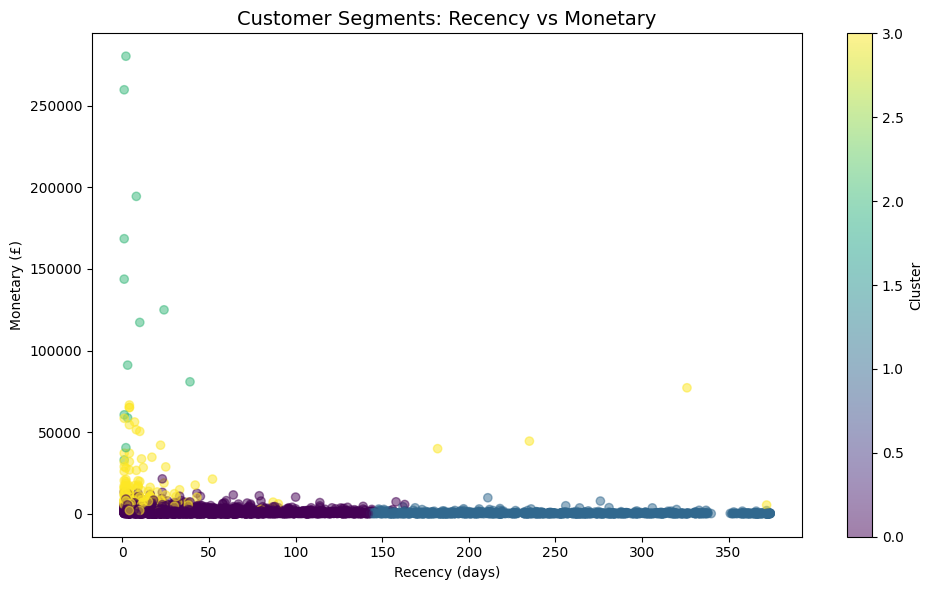

In [23]:
# Scatter plot: Recency vs Monetary
plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', alpha=0.5)
plt.title("Customer Segments: Recency vs Monetary", fontsize=14)
plt.xlabel("Recency (days)")
plt.ylabel("Monetary (£)")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig("plots/cluster_scatter.png")
plt.show()

I segmented customers into four groups using their Recency, Frequency, and Monetary (RFM) data. Cluster 0 includes loyal customers who buy often, spend a lot, and shop recently. Cluster 1 has at-risk customers who rarely buy, spend little, and haven’t purchased in a while. Cluster 2 consists of customers with moderate activity, showing potential for growth. Cluster 3 is a small group of outliers, likely very high spenders with unique buying patterns.